# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
! pip install -qq kaggle --force

     |████████████████████████████████| 58 kB 4.6 MB/s 
     |████████████████████████████████| 149 kB 31.5 MB/s 
     |████████████████████████████████| 247 kB 80.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 138 kB 85.0 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 61 kB 6.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incom

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'

In [4]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 740M/745M [00:04<00:00, 132MB/s]
100% 745M/745M [00:04<00:00, 165MB/s]


In [5]:
! unzip -q covid19-radiography-database.zip

In [6]:
! ls COVID-19_Radiography_Dataset/test/viral | wc

ls: cannot access 'COVID-19_Radiography_Dataset/test/viral': No such file or directory
      0       0       0


In [7]:
! ls COVID-19_Radiography_Dataset/COVID | wc

   3616    3616   53133


In [8]:
! ls COVID-19_Radiography_Dataset/Normal | wc

  10192   10192  162158


In [9]:
! ls COVID-19_Radiography_Dataset/Lung_Opacity | wc

   6012    6012  131157


In [10]:
! ls COVID-19_Radiography_Dataset/Viral\ Pneumonia | wc

   1345    2690   32518


# Importing Libraries

In [11]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.10.0+cu111


# Preparing Training and Test Sets

In [12]:
class_names = ['normal', 'viral', 'covid', 'opacity']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

Rename folders and make a test set by sampling randomly 30 images from each folder

In [13]:
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [14]:
! ls COVID-19_Radiography_Dataset/

 covid			      opacity
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx   test
 normal			      viral
 Normal.metadata.xlsx	     'Viral Pneumonia.metadata.xlsx'


In [15]:
! ls COVID-19_Radiography_Dataset/covid/COVID-200.png

COVID-19_Radiography_Dataset/covid/COVID-200.png


In [16]:
! ls COVID-19_Radiography_Dataset/normal/Normal-200.png

COVID-19_Radiography_Dataset/normal/Normal-200.png


# Creating Custom Dataset

In [17]:
from pathlib import Path
from PIL import Image

In [18]:
root_dir = Path('COVID-19_Radiography_Dataset/')

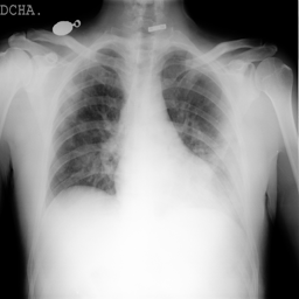

In [19]:
Image.open(root_dir/'covid/COVID-200.png')

In [20]:
root_dir

PosixPath('COVID-19_Radiography_Dataset')

In [21]:
cls_pth = [root_dir/pth for pth in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, pth)) if pth != 'test']
cls_pth

[PosixPath('COVID-19_Radiography_Dataset/covid'),
 PosixPath('COVID-19_Radiography_Dataset/normal'),
 PosixPath('COVID-19_Radiography_Dataset/viral'),
 PosixPath('COVID-19_Radiography_Dataset/opacity')]

In [22]:
def get_image_in_folder(pth):
  return [pth/fn for fn in os.listdir(pth)]

In [23]:
get_image_in_folder(cls_pth[1])[:4]

[PosixPath('COVID-19_Radiography_Dataset/normal/Normal-901.png'),
 PosixPath('COVID-19_Radiography_Dataset/normal/Normal-8607.png'),
 PosixPath('COVID-19_Radiography_Dataset/normal/Normal-7581.png'),
 PosixPath('COVID-19_Radiography_Dataset/normal/Normal-8384.png')]

In [24]:
fns = [get_image_in_folder(pth) for pth in cls_pth]

In [25]:
import itertools

In [26]:
len(list(itertools.chain(*[get_image_in_folder(pth) for pth in cls_pth])))

21045

In [27]:
pth = (root_dir/'covid'/'COVID-2.png')

In [28]:
pth.parent.stem

'covid'

In [29]:
def get_paths(pth):
  return [pth/p for p in os.listdir(pth) \
                    if os.path.isdir(os.path.join(pth, p)) \
                    if p != 'test']

In [30]:
def get_images(pth, limit=None, test=False):
  if test:
    # use all images
    fns = [get_image_in_folder(p) for p in pth] 
  else:
    # limit to a certain no of images
    fns = [random.choices(get_image_in_folder(p), k=limit) for p in pth] if limit else [get_image_in_folder(p) for p in pth]
  fns = list(itertools.chain(*fns))
  random.shuffle(fns)
  return fns

In [31]:
class ChestXRayDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir:Path, x_tfms=None, limit=None, test=False):
    # get the dir + class path
    if test:
      root_dir = root_dir/'test'
    self.cls_pth = get_paths(root_dir)
    # dict of form label: files
    self.images = get_images(self.cls_pth, limit=limit, test=test)
    self.vocab = {pth.stem: i for i, pth in enumerate(self.cls_pth)}
    self.x_tfms = x_tfms(test=test) if x_tfms is not None else None

  def __getitem__(self, idx):
    img_pth = self.images[idx]
    label = self.vocab[img_pth.parent.stem]
    image = Image.open(img_pth).convert('RGB')
    if self.x_tfms is not None:
      image = self.x_tfms(image)
    label = torch.tensor([label])
    return image, label

  def __len__(self):
    return len(self.images)


In [32]:
ds = ChestXRayDataset(root_dir)

In [33]:
ds[0]

(<PIL.Image.Image image mode=RGB size=299x299 at 0x7FC886826E90>, tensor([1]))

In [34]:
ds.vocab

{'covid': 0, 'normal': 1, 'opacity': 3, 'viral': 2}

In [35]:
len(ds)

21045

# Image Transformations

In [36]:
from torchvision import transforms as T

In [37]:
def get_tfms(test=False):
  if test:
    return T.Compose([
                    T.ToTensor(),
                    T.Resize(224),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
  else:
    return T.Compose([
                    T.ToTensor(),
                    T.Resize(224),
                    T.RandomHorizontalFlip(),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])


In [38]:
ds = ChestXRayDataset(root_dir, x_tfms=get_tfms)

In [39]:
ds[0]

(tensor([[[ 2.1208,  2.0188,  1.5392,  ...,  0.3955,  1.4650,  2.0897],
          [ 1.9874,  1.6433,  0.6915,  ...,  0.0522,  1.1209,  1.9187],
          [ 1.8182,  1.1686,  0.0149,  ..., -0.0174,  1.0198,  1.8049],
          ...,
          [ 2.2489,  2.2489,  2.2346,  ...,  1.0950,  1.6372,  2.1179],
          [ 2.2489,  2.2489,  2.2417,  ...,  1.8317,  2.0982,  2.2288],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2211,  2.2446,  2.2489]],
 
         [[ 2.2976,  2.1933,  1.7030,  ...,  0.5338,  1.6272,  2.2658],
          [ 2.1612,  1.8094,  0.8364,  ...,  0.1829,  1.2754,  2.0910],
          [ 1.9882,  1.3241,  0.1447,  ...,  0.1117,  1.1720,  1.9747],
          ...,
          [ 2.4286,  2.4286,  2.4139,  ...,  1.2489,  1.8032,  2.2947],
          [ 2.4286,  2.4286,  2.4212,  ...,  2.0020,  2.2745,  2.4080],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4002,  2.4242,  2.4286]],
 
         [[ 2.5097,  2.4058,  1.9177,  ...,  0.7537,  1.8422,  2.4779],
          [ 2.3738,  2.0236,

# Prepare DataLoader

In [40]:
train_ds = ChestXRayDataset(root_dir, x_tfms=get_tfms, limit=500)

In [41]:
test_ds = ChestXRayDataset(root_dir, x_tfms=get_tfms, test=True)

In [42]:
bs=20
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=bs, shuffle=False)

In [43]:
x, y = next(iter(train_dl))
x.shape, y.shape, len(train_dl)

(torch.Size([20, 3, 224, 224]), torch.Size([20, 1]), 100)

In [44]:
x, y = next(iter(test_dl))
x.shape, y.shape, len(test_dl)

(torch.Size([20, 3, 224, 224]), torch.Size([20, 1]), 6)

# Data Visualization

In [45]:
train_ds.vocab

{'covid': 0, 'normal': 1, 'opacity': 3, 'viral': 2}

In [46]:
len(torchvision.utils.make_grid(x))

3

In [47]:
def show_images(images, labels=None, preds=None, nrow=8):
  im = torchvision.utils.make_grid(x, nrow=nrow)
  fig, ax = plt.subplots(figsize=(12,16))
  ax.imshow(im.clip(0,1).permute(1,2,0))
  ax.axis('off')
  plt.show()

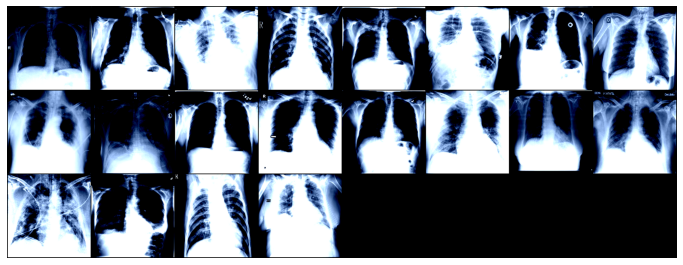

In [48]:
show_images(x)

In [49]:
def show_images(images, labels=None, preds=None, ncols=2, nrows=3):
  plt.figure(figsize=(8,6))
  images = images.permute(0,2,3,1).detach().cpu().numpy()
  mean=np.array([0.485, 0.456, 0.406])
  std=np.array([0.229, 0.224, 0.225])
  for i, image in enumerate(images):
    plt.subplot(ncols, nrows, i+1, xticks=[], yticks=[])
    image = image.clip(0,1) * std + mean
    if preds is not None and labels is not None:
      col = 'green' if preds[i]==labels[i] else 'red'
      true_label = f'{labels[i].numpy()}'
      pred_label = f'{preds[i].numpy()}'
      plt.xlabel(true_label)
      plt.ylabel(pred_label, color=col)
    plt.imshow(image)
    
  plt.tight_layout()
  plt.show()

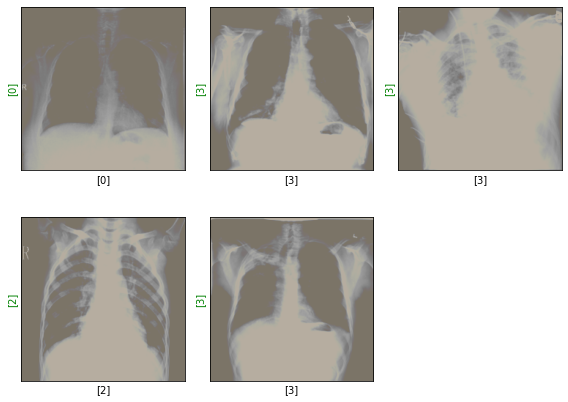

In [50]:
show_images(x[:5], labels=y[:5], preds=y[:5])

# Creating the Model

In [51]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
resnet.fc = torch.nn.Linear(512, len(train_ds.vocab))

In [53]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
loss_func = torch.nn.CrossEntropyLoss()

In [55]:
images, labels = next(iter(test_dl))
acts = resnet(images)

In [56]:
acts.shape, labels.shape

(torch.Size([20, 4]), torch.Size([20, 1]))

In [57]:
loss_func?

In [58]:
loss_func(acts, labels.squeeze())

tensor(1.3337, grad_fn=<NllLossBackward0>)

In [59]:
optim = torch.optim.Adam(resnet.parameters(), lr=3e-3)

In [60]:
def show_preds(**kwargs):
  resnet.eval()
  images, labels = next(iter(test_dl))
  acts = resnet(images)
  preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
  show_images(images, labels, preds, **kwargs)

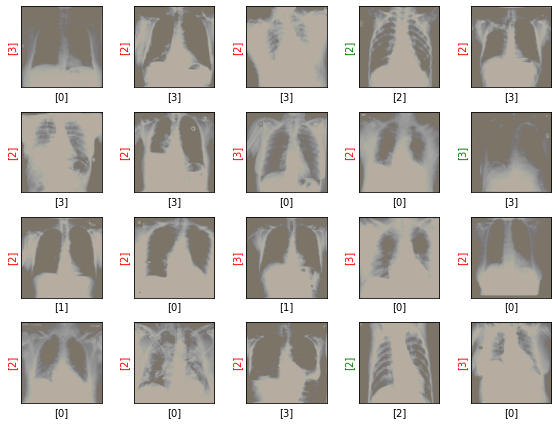

In [61]:
show_preds(ncols=4, nrows=5)

# Training the Model

In [62]:
from tqdm import tqdm 

In [63]:
@torch.no_grad()
def validate_epoch(valid_dl, resnet, loss_func=loss_func, show=True):
  resnet.eval()
  l_valid = len(valid_dl)
  valid_loss = 0.0
  valid_acc = 0.0
  for vb, (images, labels) in enumerate(tqdm(valid_dl)):
    acts = resnet(images)
    loss = loss_func(acts, labels.squeeze())
    valid_loss += loss.item()
    preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
    valid_acc += (preds==labels).float().mean().item()
  tqdm.write(f'valid_acc:{(valid_acc/l_valid):.4f} valid_loss:{(valid_loss/l_valid):.4f}')
  if show:
    show_preds(ncols=4, nrows=5)

In [65]:
def train(train_dl, valid_dl, epochs):
  for e in range(epochs):
    print(f'epoch {e}')
    resnet.train()
    train_loss = 0.0
    train_acc = 0.0
    l_train = len(train_dl)
    for tb, (images, labels) in enumerate(tqdm(train_dl)):
      acts = resnet(images)
      # opt
      optim.zero_grad()
      # loss
      loss = loss_func(acts, labels.squeeze())
      train_loss += loss.item()
      loss.backward()
      optim.step()
      # preds train
      preds = torch.softmax(acts, -1).argmax(-1, keepdim=True)
      train_acc += (preds==labels).float().mean().item()
    
    tqdm.write(f'train_acc:{(train_acc/l_train):.4f} train_loss:{(train_loss/l_train):.4f}')
    if e%2==0:
      # validate every 2 epochs
      validate_epoch(valid_dl, resnet, loss_func=loss_func, show=True)
    

In [ ]:
train(train_dl, test_dl, 15)

epoch 0


 82%|████████▏ | 82/100 [04:55<01:03,  3.55s/it]